In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', 500)

## 1. Understanding objective and the datasets
Data (loads of 20 zones and temperature of 11 stations) history ranges from the 1st hour of 2004/1/1 to the 6th hour of 2008/6/30.

Given actual temperature history, the 8 weeks below in the load history are set to be missing and are required to be backcasted. It's OK to use the entire history to backcast these 8 weeks.

2005/3/6 - 2005/3/12;

2005/6/20 - 2005/6/26;

2005/9/10 - 2005/9/16;

2005/12/25 - 2005/12/31;

2006/2/13 - 2006/2/19;

2006/5/25 - 2006/5/31;

2006/8/2 - 2006/8/8;

2006/11/22 - 2006/11/28;

In addition, the particpants need to forecast hourly loads from 2008/7/1 to 2008/7/7. No actual temperatures are given for this week. 

In [2]:
load_df = pd.read_csv("Data/Load_history.csv", thousands=",")
temp_df = pd.read_csv("Data/temperature_history.csv")

In [3]:
load_df.head()

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,16853.0,16450.0,16517.0,16873.0,17064.0,17727.0,18574.0,19355.0,19534.0,18611.0,17666.0,16374.0,15106.0,14455.0,13518.0,13138.0,14130.0,16809.0,18150.0,18235.0,17925.0,16904.0,16162.0,14750.0
1,1,2004,1,2,14155.0,14038.0,14019.0,14489.0,14920.0,16072.0,17800.0,19089.0,19577.0,20047.0,19770.0,18564.0,18137.0,17046.0,16127.0,15448.0,15839.0,17727.0,18895.0,18650.0,18443.0,17580.0,16467.0,15258.0
2,1,2004,1,3,14439.0,14272.0,14109.0,14081.0,14775.0,15491.0,16536.0,18197.0,19109.0,18012.0,17200.0,15950.0,14978.0,14162.0,13507.0,13414.0,13826.0,15825.0,16996.0,16394.0,15406.0,14278.0,13315.0,12424.0
3,1,2004,1,4,11273.0,10415.0,9943.0,9859.0,9881.0,10248.0,11016.0,12780.0,15108.0,15680.0,15280.0,14605.0,14689.0,14642.0,14207.0,13614.0,14162.0,16237.0,17430.0,17218.0,16633.0,15238.0,13580.0,11727.0
4,1,2004,1,5,10750.0,10321.0,10107.0,10065.0,10419.0,12101.0,14847.0,15259.0,14045.0,14009.0,14332.0,13908.0,13981.0,13865.0,13845.0,14350.0,15501.0,17307.0,18786.0,19089.0,19192.0,18416.0,17006.0,16018.0


In [4]:
temp_df.head()

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,46,46,45,41,39,35,33.0,33.0,36.0,47.0,53.0,54.0,55.0,55.0,55.0,55.0,52.0,46.0,40.0,40.0,39.0,38.0,40.0,41.0
1,1,2004,1,2,43,44,46,46,47,47,47.0,47.0,47.0,47.0,47.0,49.0,52.0,56.0,54.0,56.0,57.0,53.0,50.0,47.0,46.0,45.0,45.0,45.0
2,1,2004,1,3,45,46,46,44,43,46,46.0,47.0,51.0,55.0,56.0,59.0,65.0,68.0,69.0,68.0,68.0,65.0,64.0,63.0,62.0,63.0,63.0,62.0
3,1,2004,1,4,63,62,62,62,60,60,60.0,62.0,60.0,64.0,64.0,66.0,71.0,70.0,71.0,72.0,71.0,68.0,67.0,67.0,65.0,64.0,65.0,64.0
4,1,2004,1,5,64,63,65,64,64,64,64.0,64.0,65.0,66.0,66.0,67.0,68.0,68.0,66.0,66.0,66.0,66.0,63.0,54.0,52.0,49.0,47.0,47.0


We see that the 11 station_ids in the temperature history do not correspond to the 20 zone_ids in the load history, and we will need an algorithm to select stations representing a zone if we seek to use temperature data. 

In [5]:
load_df[load_df.isna().any(axis=1)]

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
430,1,2005,3,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
431,1,2005,3,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
432,1,2005,3,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
433,1,2005,3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
434,1,2005,3,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
435,1,2005,3,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
436,1,2005,3,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
536,1,2005,6,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,1,2005,6,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
538,1,2005,6,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We note that the NaN values in load correspond to the dates that we must backcast and forecast. We will store these in a separate dataframe and drop them from load_df.

In [6]:
load_to_pred_df = load_df[load_df.isna().any(axis=1)]
load_df = load_df.dropna()

In [7]:
temp_df[temp_df.isna().any(axis=1)]

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
1642,1,2008,6,30,74,74,74,74,74,75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3285,2,2008,6,30,66,65,64,64,64,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4928,3,2008,6,30,77,76,76,75,75,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6571,4,2008,6,30,72,72,72,72,72,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8214,5,2008,6,30,73,74,74,73,72,72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9857,6,2008,6,30,70,70,70,70,70,68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11500,7,2008,6,30,74,73,72,71,71,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13143,8,2008,6,30,72,71,71,71,70,71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14786,9,2008,6,30,75,72,72,69,69,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16429,10,2008,6,30,70,70,70,70,70,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There also appear to be missing values in temp_df a couple hours before thee dates we need to forecast. We will get back to this later, as we want to first predict loads solely off historical load data.

## 2. Load data
In this part, we seek to better understand load data and if we can use historical load data to backcast and forecast the missing values.

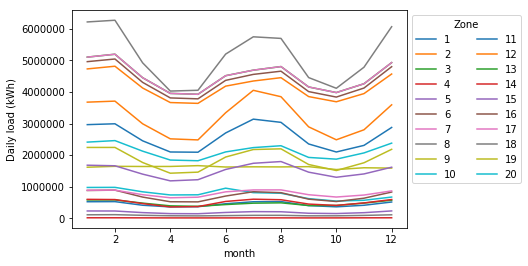

In [11]:
daily_load_by_month = (load_df.drop(['year', 'day'], axis=1)
                       .groupby(['month', 'zone_id']).mean()
                       .sum(axis=1).to_frame('Daily Load').reset_index())
ax = daily_load_by_month.pivot_table(values='Daily Load', index='month', columns='zone_id').plot()
ax.set_ylabel('Daily load (kWh)')
ax.legend(title='Zone', loc=0, ncol=2, bbox_to_anchor=(1,1))

In general, we see that the load varies almost sinusoidally with the month of year across zones. This makes sense as we expect energy demand for heating and cooling to increase during the winter and summer months, respectively.